In [1]:
#first import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os

#tensorflow
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model

#import time
import time

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance, ImageOps
import random
import cv2

In [7]:
#get the images directory
image_dir = os.getcwd() + '/images/finding_waldo'

#get the background and waldo image directory
background_dir = image_dir + '/wheres_wally.jpg'
waldo_dir = image_dir + '/waldo.png'

waldo_path = waldo_dir
background_path = background_dir

waldo_png = Image.open(waldo_path).convert("RGBA")
background_img = Image.open(background_path).convert("RGB")

In [8]:
WALDO_W, WALDO_H = 60, 100
waldo_png = waldo_png.resize((WALDO_W, WALDO_H), Image.LANCZOS)

In [9]:
BG_W, BG_H = 500, 350

def generate_training_sample():
    bg = background_img.resize((BG_W, BG_H)).copy()
    
    x = random.randint(0, BG_W - WALDO_W)
    y = random.randint(0, BG_H - WALDO_H)

    bg.paste(waldo_png, (x, y), waldo_png)

    x1, y1 = x, y
    x2, y2 = x + WALDO_W, y + WALDO_H

    img_arr = np.array(bg).astype(np.float32) / 255.0
    
    return img_arr, np.array([x1, y1, x2, y2], dtype=np.float32), np.array([1.0], dtype=np.float32)

In [10]:
def data_generator(batch_size=16):
    while True:
        X = np.zeros((batch_size, BG_H, BG_W, 3))
        y_box = np.zeros((batch_size, 4))
        y_cls = np.zeros((batch_size, 1))

        for i in range(batch_size):
            img, box, cls = generate_training_sample()
            X[i] = img
            y_box[i] = box
            y_cls[i] = cls

        yield X, {"class_output": y_cls, "box_output": y_box}

In [11]:
inputs = layers.Input(shape=(BG_H, BG_W, 3))

x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 6, padding='valid', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 6, padding='valid', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

# Shared feature map
feat = x

# Classification head
c = layers.Flatten()(feat)
c = layers.Dense(1024, activation='relu')(c)
c = layers.Dense(512, activation='relu')(c)
class_output = layers.Dense(1, activation='sigmoid', name='class_output')(c)

# Bounding box head
b = layers.Flatten()(feat)
b = layers.Dense(1024, activation='relu')(b)
b = layers.Dense(512, activation='relu')(b)
box_output = layers.Dense(4, name='box_output')(b)  # x1, y1, x2, y2

model = models.Model(inputs=inputs, outputs=[class_output, box_output])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 350, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 350, 500,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 350, 500,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 175, 250,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 175, 250,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 175, 250,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 87, 125,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 82, 120,   │     73,792 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 82, 120,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 41, 60,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 36, 55,    │    147,520 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 55,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 18, 27,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 31104)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 31104)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 31,851,520 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │ 31,851,520 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 64,982,309 (247.89 MB)

 Trainable params: 64,981,957 (247.89 MB)

 Non-trainable params: 352 (1.38 KB)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={"class_output": "binary_crossentropy", "box_output": "mse"},
    metrics={"class_output": "accuracy", "box_output": "mse"},
)

In [13]:
BATCH = 16

history = model.fit(
    data_generator(BATCH),
    steps_per_epoch=100,
    epochs=5,    # increase to 10–15 for stronger model
    verbose=1
)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - box_output_loss: 4838.4819 - box_output_mse: 4838.4819 - class_output_accuracy: 0.9906 - class_output_loss: 0.0094 - loss: 4838.4912 
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - box_output_loss: 109.1521 - box_output_mse: 109.1521 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 109.1521
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - box_output_loss: 81.4774 - box_output_mse: 81.4774 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 81.4774
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - box_output_loss: 79.0185 - box_output_mse: 79.0185 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 79.0185
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - box_output_loss: 106.4506 - box_output_mse: 106.4506 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 106.4506


In [19]:
# save
model.save("waldo_detector.keras")

# load later
import tensorflow as tf
model = tf.keras.models.load_model("waldo_detector.keras")

/opt/anaconda3/envs/whereswaldo/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 30 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
def detect_waldo_in_page(page_path):
    img = Image.open(page_path).convert("RGB")
    page_w, page_h = img.size

    resized = img.resize((BG_W, BG_H))
    X = np.array(resized).astype(np.float32) / 255.0
    X = X.reshape(1, BG_H, BG_W, 3)

    cls_pred, box_pred = model.predict(X)
    box_pred = box_pred[0]

    x1, y1, x2, y2 = box_pred

    # Scale back to original resolution
    sx = page_w / BG_W
    sy = page_h / BG_H

    X1 = int(x1 * sx)
    Y1 = int(y1 * sy)
    X2 = int(x2 * sx)
    Y2 = int(y2 * sy)

    # Draw
    img_np = np.array(img)
    cv2.rectangle(img_np, (X1, Y1), (X2, Y2), (255,0,0), 4)

    plt.figure(figsize=(10,10))
    plt.imshow(img_np)
    plt.axis("off")
    plt.show()

    print("Confidence:", cls_pred[0][0])
    print("Box:", X1, Y1, X2, Y2)

In [22]:
from PIL import Image

waldo_path = waldo_dir
background_path = background_dir

# resize waldo to match training size
waldo = Image.open(waldo_path).convert("RGBA")
waldo = waldo.resize((60, 100), Image.LANCZOS)

# choose coordinates manually for testing
x, y = 200, 150

bg = Image.open(background_path).convert("RGB")
bg.paste(waldo, (x, y), waldo)   # use waldo as its own mask
bg.save("test_waldo_image.jpg")
bg.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


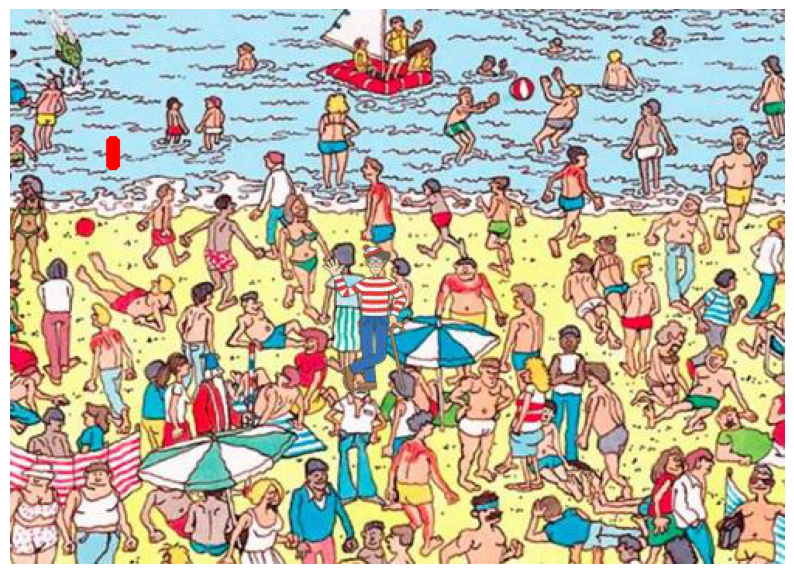

Confidence: 1.0
Box: 64 84 68 101


In [27]:
detect_waldo_in_page("test_waldo_image.jpg")